In [63]:
import numpy as np
import dxchange
import holotomo
import tifffile
import matplotlib.pyplot as plt

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [64]:
n = 1024  # object size in each dimension
ntheta = 4  # number of angles (rotations)

pn = 64  # tomography chunk size for GPU processing
ptheta = 4  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 17.05  # [keV] xray energy
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
ndist = 4
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 270e-3# positions of the probe and code for reconstruction
z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


[0.00420013 0.00420013 0.00420013 0.00420013] [-0.00414823 -0.00414823 -0.00414823 -0.00414823]
[5.18963367e-05 5.18963367e-05 5.18963367e-05 5.18963367e-05]


## Read data

data/modeling/data_siemens_codes_1024_0.tiff
data/modeling/data_siemens_codes_1024_1.tiff
data/modeling/data_siemens_codes_1024_2.tiff
data/modeling/data_siemens_codes_1024_3.tiff


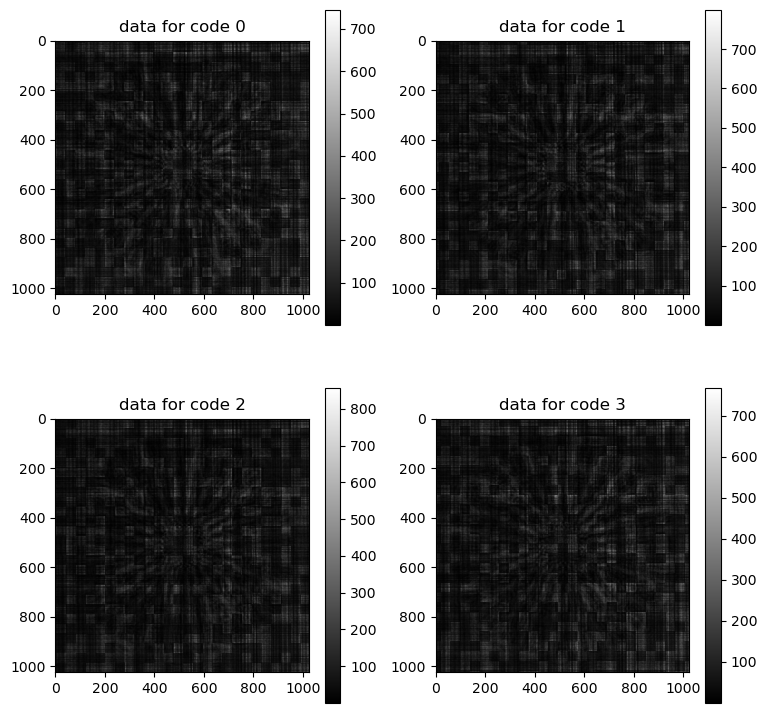

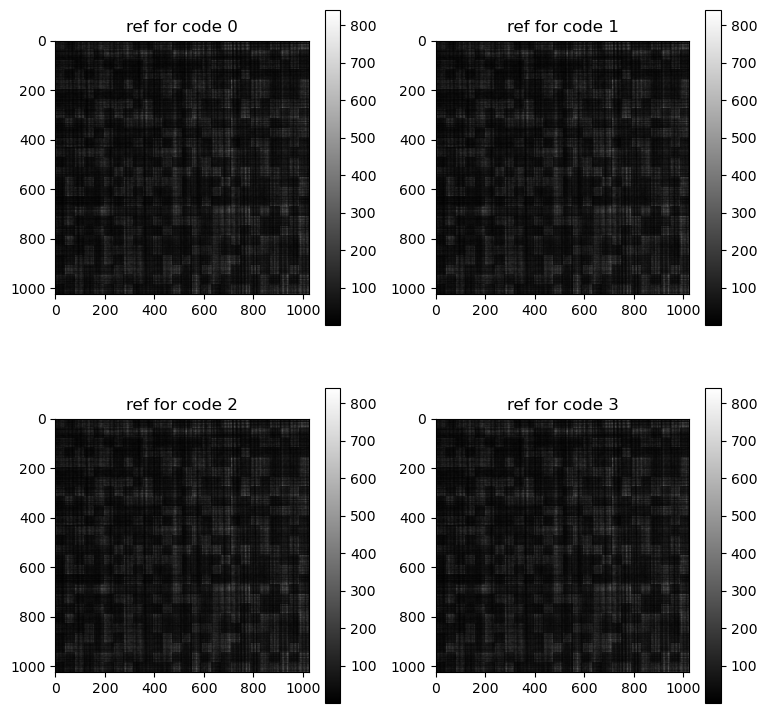

In [65]:
data0 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref0 = np.zeros([ndist,n,n],dtype='float32')
for k in range(ndist):
    print(f'data/modeling/data_siemens_codes_{n}_{k}.tiff')
    data0[k] = dxchange.read_tiff(f'data/modeling/data_siemens_codes_{n}_{k}.tiff')
    ref0[k] = dxchange.read_tiff(f'data/modeling/ref_siemens_codes_{n}_0.tiff')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data0[0,0],cmap='gray')
axs[0,0].set_title('data for code 0')
fig.colorbar(im)
im=axs[0,1].imshow(data0[1,0],cmap='gray')
axs[0,1].set_title('data for code 1')
fig.colorbar(im)
im=axs[1,0].imshow(data0[-2,0],cmap='gray')
axs[1,0].set_title('data for code 2')
fig.colorbar(im)
im=axs[1,1].imshow(data0[-1,0],cmap='gray')
axs[1,1].set_title('data for code 3')
fig.colorbar(im)
plt.show()
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(ref0[0],cmap='gray')
axs[0,0].set_title('ref for code 0')
fig.colorbar(im)
im=axs[0,1].imshow(ref0[1],cmap='gray')
axs[0,1].set_title('ref for code 1')
fig.colorbar(im)
im=axs[1,0].imshow(ref0[-2],cmap='gray')
axs[1,0].set_title('ref for code 2')
fig.colorbar(im)
im=axs[1,1].imshow(ref0[-1],cmap='gray')
axs[1,1].set_title('ref for code 3')
fig.colorbar(im)
plt.show()

## Read the probe

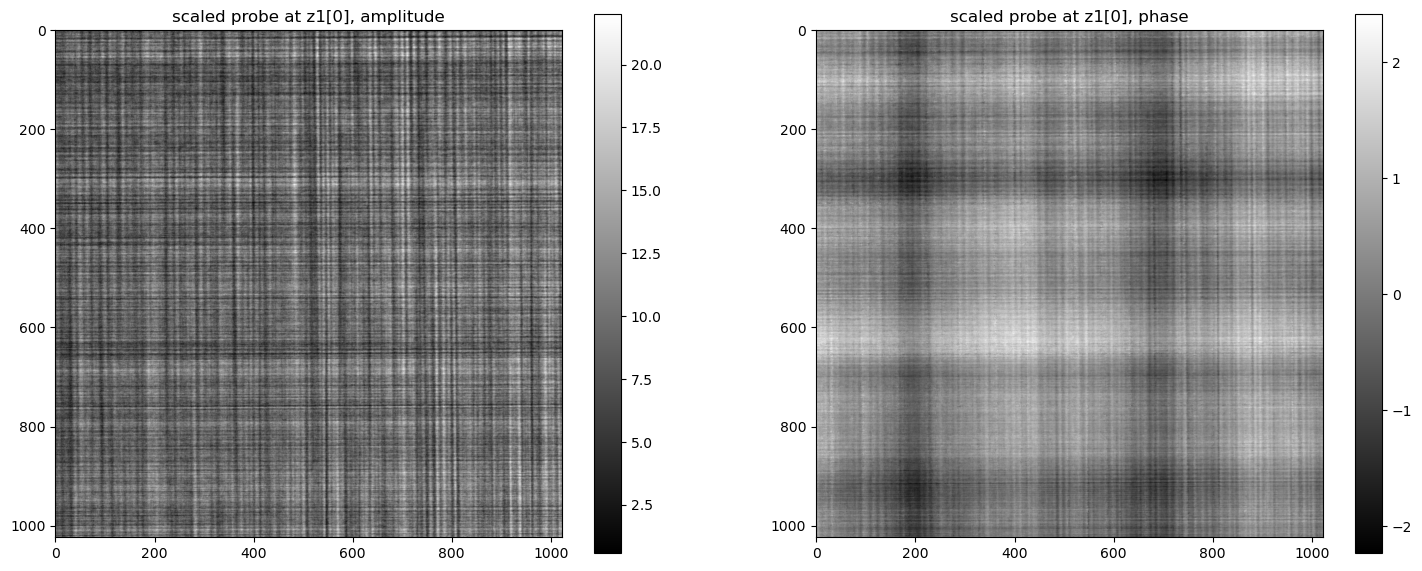

In [66]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0:ndist]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0:ndist]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
prb[:] = prb[0]
# prb[:] = 1
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

## Read the transmittance functions for the code

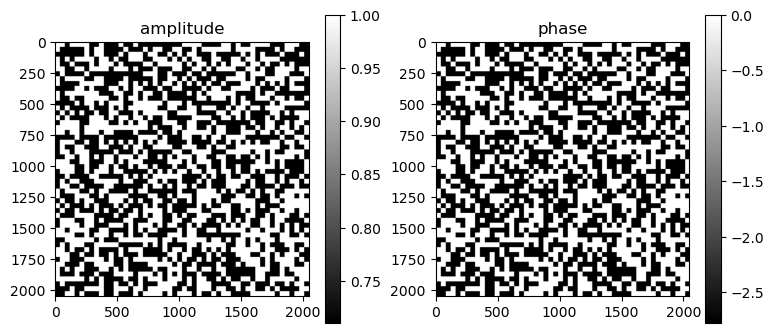

In [70]:
code = np.ones([1,2*n,2*n],dtype='complex64')
code[0] = (tifffile.imread(f'data/modeling/psiill_abs_{n}.tiff')*np.exp(1j* tifffile.imread(f'data/modeling/psiill_angle_{n}.tiff')))
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(code[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(code[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

shifts = np.load('shifts.npy')
shifts_code = np.load('shifts_code.npy')

## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [68]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distancesp[:1]) 


In [71]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
print(shifts_code.shape)

prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
arr2 = pslv.fwd_holo_batch(arr1, prb1, code=code, shifts_code=shifts_code)
arr3 = pslv.adj_holo_batch(arr2, prb1, code=code, shifts_code=shifts_code)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, code=code, shifts_code=shifts_code)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(4, 4, 2)
(3022116700000000-124256580j)
(3022119000000000-1223.273j)
(3022117000000000-217251840j)


## Conjugate gradient solver

In [72]:
import cupy as cp
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, code=None, shifts_code=None, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    data = cp.sqrt(data)
    data_ref = cp.sqrt(data_ref)

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    psi_nil = psi*0+1
    shifts_nil = shifts*0
    shifts_code_nil = shifts_code[:,0]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2

            fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            dprb*=-1/(pslv.ntheta+1)

            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  

        if upd_prb==True and upd_psi==False and i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(prb[0]).get(),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(prb[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
        elif i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(psi[0,n//2:-n//2,n//2:-n//2]).get(),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(psi[0,n//2:-n//2,n//2:-n//2]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/siemens_codes/{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/siemens_codes/{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    codes_gpu = cp.array(code)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        shifts_gpu = cp.array(shifts[:,ids])        
        shift_codes_gpu = cp.array(shifts_code[:,ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts_gpu,codes_gpu,shift_codes_gpu,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


(4, 1, 1024, 1024)
0) gammapsi=0.5 gammaprb=1, err=3.76687e+07


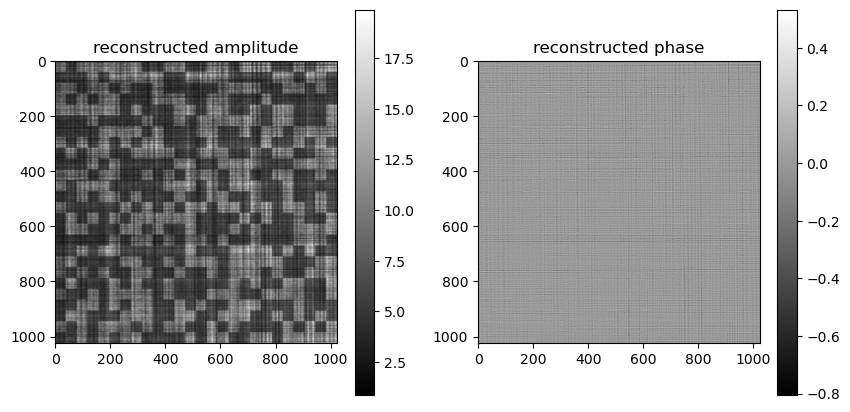

16) gammapsi=0.5 gammaprb=1, err=5.84800e-03


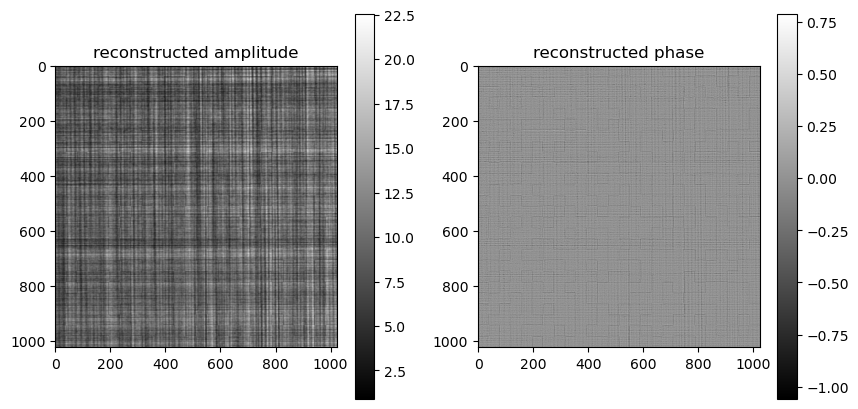

32) gammapsi=0.5 gammaprb=1, err=1.71099e-05


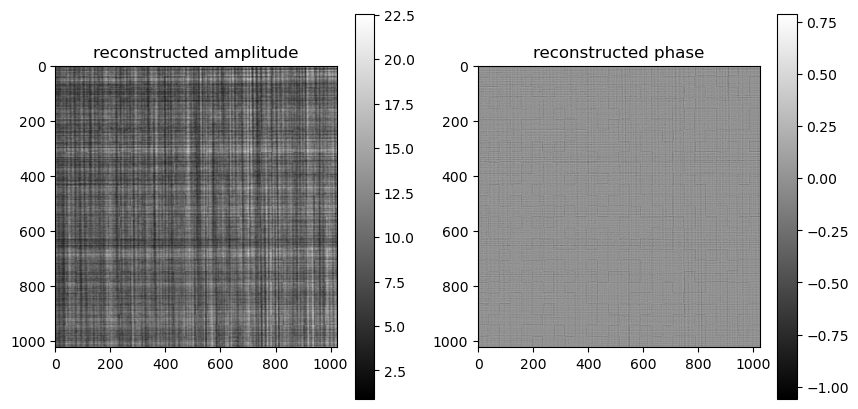

48) gammapsi=0.5 gammaprb=1, err=1.71658e-05


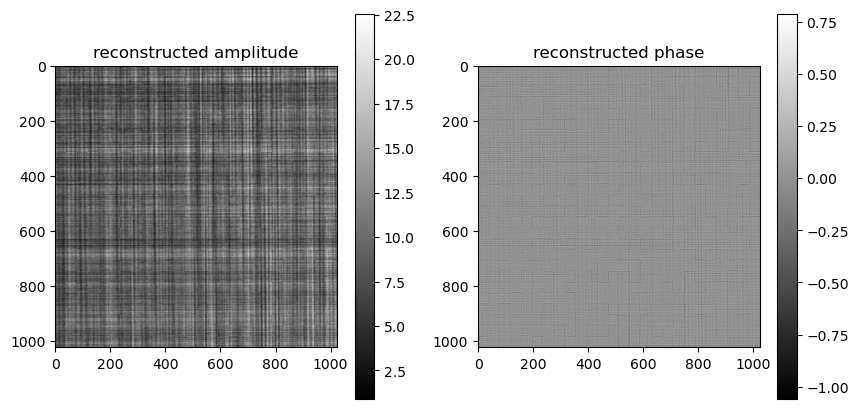

64) gammapsi=0.5 gammaprb=1, err=1.69022e-05


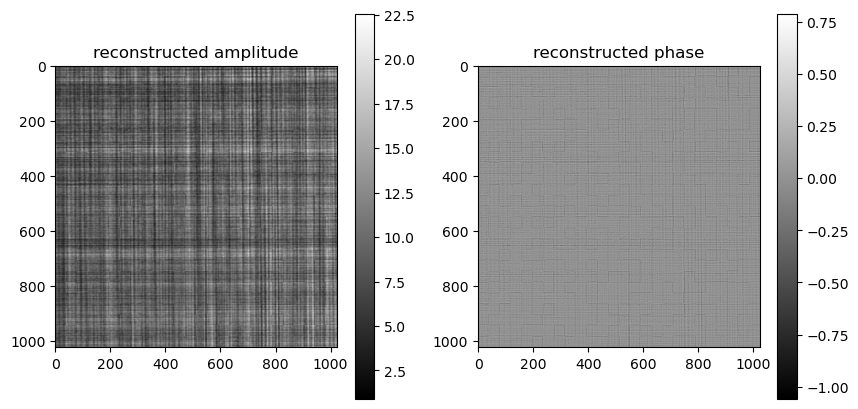

80) gammapsi=0.5 gammaprb=1, err=1.70344e-05


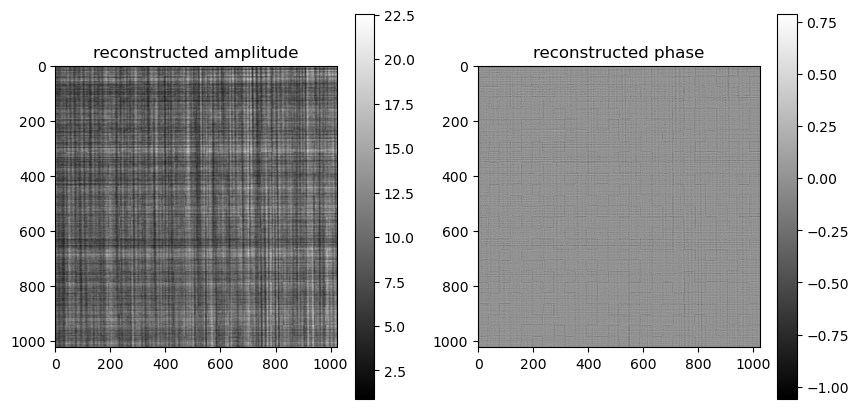

96) gammapsi=0.5 gammaprb=1, err=1.71149e-05


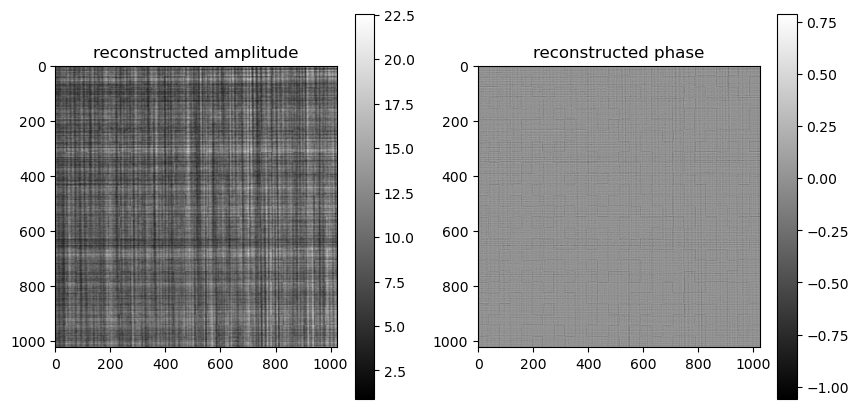

112) gammapsi=0.5 gammaprb=1, err=1.69214e-05


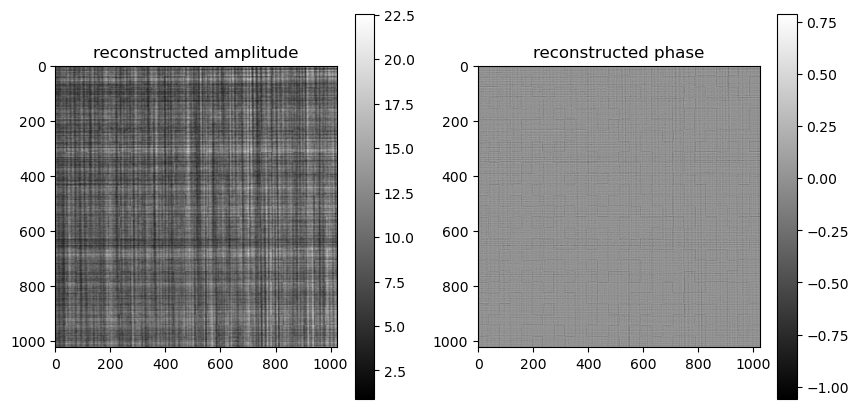

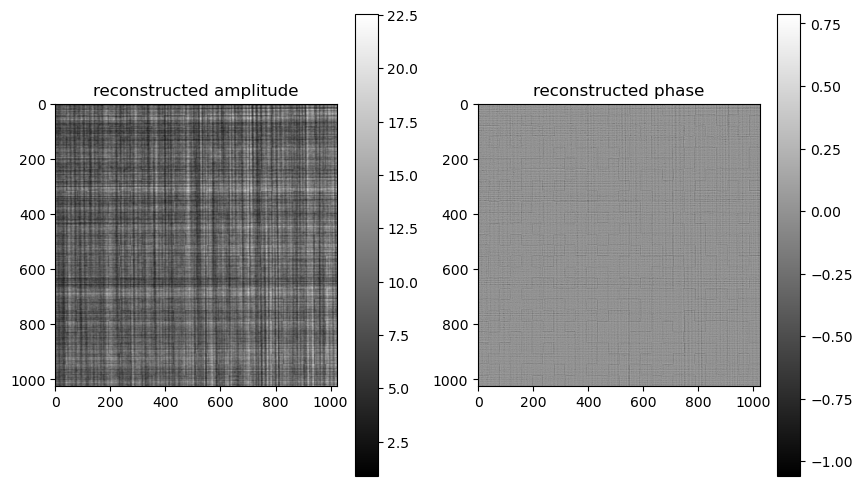

In [75]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distancesp) 

rec = np.ones([1,2*n,2*n],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = ref[:,np.newaxis]
print(data_ref.shape)
shifts_ref = np.array(shifts)[:,:1]*0
shifts_codes_ref = np.array(shifts_code)[:,:1]*0
_,rec_prb0 = cg_holo_batch(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 128, shifts_ref, code, shifts_codes_ref, False,True,16,16,0.5,1)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)





In [76]:
shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
rec = np.ones([ntheta,2*n,2*n],dtype='complex64')
# # use only the abs value of the probe as initial guess
rec_prb[:] = rec_prb0
rec,rec_prb = cg_holo_batch(pslv, pslv0, data, data_ref, rec, rec_prb, 16, shifts_rec, code, shifts_code, True,True,4,4,0.5,1)


ValueError: Out shape is mismatched